This is the script to build and train convnet model which categorize between class: mountain, no mountain
model is then saved to ./models folder

In [145]:
import os
import tensorflow as tf

Import Image Dataset

In [ ]:
# import dataset from directory
DIR_PATH = os.path.join('Detectors', 'cleaned_data', 'mountain_dataset_all')
IMAGE_SIZE = 244
BATCH_SIZE = 32
# =============================
# Create Image Dataset form Directory
# =============================
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_PATH,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='training'

)
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    DIR_PATH,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)

In [ ]:
# Visualize data
images = None
labels = None
class_names = ds_train.class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Image Pre-Processing

In [32]:
# data augmentation
with tf.device('/CPU:0'): # for Apple Silicon which does not yet support random() with GPU
    augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.3, 0.8)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(0.0, 0.1),
                                                                interpolation='bilinear',
                                                                seed=123)
    ])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

augmented_ds_train = ds_train.map(
    lambda x, y: (augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

augmented_ds_train = augmented_ds_train.cache()
augmented_ds_train = augmented_ds_train.prefetch(buffer_size=10)

In [34]:
rescaling = tf.keras.Sequential([
    # rescaling
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

Build Model

In [137]:
model = tf.keras.models.Sequential(
    [
        rescaling,
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2, activation='softmax')
    ]
)

In [ ]:
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

In [139]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(augmented_ds_train, epochs=50, validation_data=ds_val)

In [ ]:
test_loss, test_acc = model.evaluate(ds_val)
print(test_acc)

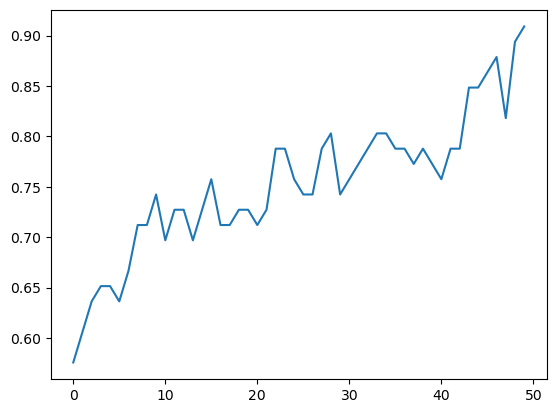

In [141]:
acc = history.history['val_accuracy']
# print(acc)

plt.plot(acc)
plt.show()

In [144]:
model.save(os.path.join('Detectors', "models", "mountain_recognition_basic_v1.h5"))

In [ ]:
# test sample images:
import os
import numpy as np
import matplotlib.pyplot as plt
SAMPLE_DIR = os.path.join('Detectors', 'sample_images', 'mountain testing')

ds_testing = tf.keras.preprocessing.image_dataset_from_directory(
    SAMPLE_DIR,
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=None
)

In [52]:
def get_prediction(prediction, _class_names):
    one_hot_array = prediction[0]
    max_confidence = max(one_hot_array)
    if max_confidence < 0.5:
        return 'unsure'
    else:
        return _class_names[one_hot_array.argmax()]

In [ ]:
for images in ds_testing:
    for i in range(25):
        image = images[i]
        plt.imshow(image.numpy().astype("uint8"))
        predictions = model.predict(np.expand_dims(image, axis=0))
        plt.title(get_prediction(predictions, class_names))
        plt.show()